In [3]:
import wikipedia
wikipedia.set_lang('ja')
# p = wikipedia.page('朝井リョウと加藤千恵のオールナイトニッポン0(ZERO)')
# p = wikipedia.page('ウレロ☆シリーズ')
p = wikipedia.page('アルコ&ピースのオールナイトニッポンシリーズ')
# p = wikipedia.page('水曜どうでしょう')

In [4]:
import re
import wikipedia
import bs4.element as bs4elem
from bs4 import BeautifulSoup

class WikiScraper(object):
    def __init__(self):
        self._name = ''
        self._page = ''
        self._bsObj = None
        self._headlines = []
        self._headline_tag = 'h3'
        self._last_key = ''
        self._result = dict()
    
    def __str__(self):
        output = self._name + '\n'
        for k, v in self._result.items():
            output +=  k + ' : ' 
            for staff in set(v):
                output += staff + ',       '
            output += u'\n'
        return output.encode('utf-8')

    
    def load_wiki(self, name, lang):
        self._name = name
        wikipedia.set_lang(lang)
        try:
            self._page = wikipedia.page(name)
        except:
            print('Can not open wikipage of '+self._name+' with lang '+lang)

        self._bsObj = BeautifulSoup(self._page.html(), "html.parser")   
    
    
    def load_html(self, name, html):
        self._bsObj = BeautifulSoup(html, "html.parser")   
        self._name = name
    
    
    def find_headline(self, name):
        headers = self._bsObj.find_all(class_='mw-headline')
        self._headlines = []
        for h in headers:
                if h.text == name:
                    self._headline_tag = h.parent.name
                    self._headlines.append(h)

    def cleanup_text(func):
        def wrapper(self, key, data):
            value = []
            data = data.encode('utf-8')
            data = re.sub('(（|\(|\（|［|\[).+?(）|\）|\)|］|\])','', data) #remove brackets
            data = data.strip()  #remove \n, and blank from head and tail

            #exception
            exception = [u'A・T・C事務所']
            for e in exception:
                if e.encode('utf-8') in data:
                    value.append(e)
                    data = data.replace(e.encode('utf-8'),'')
            
            value = func(key, data, value)
            
            if key in self._result:
                self._result[key].extend(value)
            else:
                 self._result[key] = value

        return wrapper

    @cleanup_text
    def cleanup_value_list(key, data, value):
        data = re.split('-', data)[0]
        value.extend(re.split(u'[,、・/／→\n]', data.decode('utf-8'))) #separate multiple staffs    
        for i, v in enumerate(value): #remove ※
            value[i]  = re.split(u'※', v)[0].strip()
        
        return value

    @cleanup_text
    def cleanup_value_infobox(key, data, value): 
        data = re.split(u'[※]', data)[0]
        value.extend(re.split(u'[,、・/→\n]', data.decode('utf-8'))) #separate multiple staffs    
        return value
                
    def find_list(self, elt, parent=''):
        for e in elt.find_all('ul'):
            for s in e.parent.strings:
                parent += s.strip() + ' '
                self._last_key = parent
                break            
            self.find_list(e, parent)
            parent = ''
            e.parent.decompose()
        for e in elt.find_all(['dd', 'li']):
            data = e.text
            if e.name == 'dd':
                data = self._last_value = self._result[self._last_key][-1]+ data
                key = self._last_key
                self._last_value = ''
            
            elif not re.search(u'[：-]',data): 
                key = parent.strip()
                self._last_value = ''
                
            else:
                #temp for 水曜どうでしょう　& アルピーANN
                if parent != '':
                    key = parent
                    if re.search(u'：',data):
                        data = re.split(u'：', data)
                        key += data[0]
                        data = data[1]
                    elif re.search(u'-',data):
                        data = re.split(u'-', data)
                        key = parent
                        data = data[0]
                        
                else:
                    datas = re.split(u'[：-]', data)
                    data = datas[1]
                    key = parent + datas[0].strip()                    

            value = self.cleanup_value_list(key, data)

            self._last_key = key
                
    def get_list_from_headline(self, name):
        self.find_headline(name)
        for headline_start in self._headlines:
            finish = False
            for elt in headline_start.parent.nextSiblingGenerator():
                if elt.name is not None and re.match('h[1-6]', elt.name) and elt.name <= self._headline_tag:
                    break

                if hasattr(elt, 'text'):
                    self.find_list(elt)

    def find_tr(self, table):
        rows = table.findAll('tr')
        for row in rows:
            if len(row.findAll('tr')):
                self.find_tr(row)
            else:
                index = row.find('th')
                if index is not None:
                    key = index.get_text()
                    value = row.find('td')
                    if value is not None:
                        value_str = re.sub('</*br/*>', '\n', str(value))
                        value = BeautifulSoup(value_str, "html.parser")
        #                    value = value.get_text().split('\n')
                        value = self.cleanup_value_infobox(key, value.get_text())
        #                     self._result[key] = value

    def get_table(self, class_name='infobox'):
        tables = self._bsObj.findAll('table',{'class':class_name})
        for table in tables:
            self.find_tr(table)
                    
wsc = WikiScraper()
#wsc.load_wiki('朝井リョウと加藤千恵のオールナイトニッポン0(ZERO)', 'ja')
wsc.load_html(p.title, p.html())
wsc.get_list_from_headline(u'スタッフ')
wsc.get_table('infobox')
print wsc

アルコ&ピースのオールナイトニッポンシリーズ
プロデューサー : 宗岡芳樹,       
ディレクター  : 宗岡芳樹,       石井玄,       
ネットワーク : NRN,       
テーマ曲 : 下記「テーマ曲」参照,       
パーソナリティ : アルコ&ピース,       
放送時間 : 毎週木曜日 27:00 - 28:30,       
放送期間 : 2012年8月31日,       12月1日,       2013年1月5日,       4月4日 - 2016年3月24日,       ,       
構成  : 福田卓也,       
ディレクター : 石井玄,       
放送局 : ニッポン放送,       
構成 : 畠山健,       
AD  : サイトー,       
ジャンル : バラエティ番組,       
放送方式 : 生放送,       
プロデューサー  : 節丸雅予,       
公式サイト : 公式サイト,       



In [5]:
import pandas as pd
data = pd.read_csv("contents.csv",index_col=0)
wscs = []
for i in data.index.values:
    wsc = WikiScraper()
    wsc.load_wiki(i.decode('utf-8'), 'ja')
#     wsc.load_html(p.html())
    wsc.get_list_from_headline(u'スタッフ')
    wsc.get_table('infobox')
    
    wscs.append(wsc)
    
    print i
    print '-------------------------------------'
    print wsc
    print '+++++++++++++++++++++'

水曜どうでしょう
-------------------------------------
水曜どうでしょう
制作応援 : 福屋渉,       
外部リンク : 公式サイト,       
ENG音声 : 松澤聡,       末永大輔,       中田靖博,       
放送国 : 日本,       
ジャンル : バラエティ番組,       
制作著作 : 北海道テレビ,       
題字 : 浜田次朗,       
構成 : 森崎博之,       
制作局 : 北海道テレビ,       
プロデューサー : 矢澤浩,       明田晋弥,       川筋雅文,       この他にも企画によっては違う番組のスタッフが応援でロケに同行したり,       本職のカメラマンが企画を撮影したこともある。この他にも企画によっては違う番組のスタッフが応援でロケに同行したり,       土井巧,       本職のカメラマンが企画を撮影したこともある。,       四宮康雅,       
CG : BgBee,       松尾裕介,       前田育宏,       畠山幸太,       
放送時間 : ,       木曜日 0:50 - 1:20,       23:15 - 23:45,       水曜日 23:25 - 23:55,       23:09 - 23:39,       
ENG撮影 : 鈴木武司,       坂本忠昭,       
スタイリスト : 小松江里子,       
ディレクター（デジタルビデオ撮影） : 嬉野雅道,       
音響効果 : 工藤哲也,       
放送期間 : 1996年10月10日 - 1998年3月26日,       1998年4月1日 - 2002年9月25日,       
協力 : CREATIVE OFFICE CUE,       
出演者 : 鈴井貴之,       安田顕,       ほか,       嬉野雅道,       どうでしょう班,       大泉洋,       藤村忠寿,       
編集 : 西村静志,       
ディレクター : 加藤朋秀,       清水浩,       
撮影 : 佐々木耕,       
企画 : 

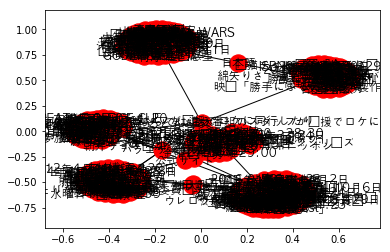

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for wsc in wscs:
    G.add_node(wsc._name, color='blue', size=100)
    result = [wsc._name]
    for k, v in wsc._result.items():
            result.extend(v)
#         for data in v:
            
    G.add_star(result)

# nx.draw_networkx(G,font_family='AppleGothic')
plt.show()
nx.write_gexf(G, 'test.gexf')